# SHAP scores
 
In this notebook we will apply a novel xAI package to our data. We will explain the predictions model makes using SHAP scores. Please refer to the video from DA5 to learn more what the scores mean. In this notebook, we focus on application.

*Note*: In this notebook, focus is on applying SHAP. Propoer documentation for all other steps is not provided.




First, let's import the packages and run the model. This is the same model as used in the tutorial. We will not go over all the steps here.

In [ ]:
import pandas as pd
import seaborn as sns
%matplotlib inline

from sklearn.linear_model import LogisticRegression, LinearRegression
import statsmodels.api as sm
import numpy as np

import shap

Let's prepare the data and models. You can find detailed explanations in the tutorial video.

In [4]:
data = pd.read_csv('googlestore.csv')

/var/folders/jk/nv4fcn7x6k37tk2nhtsd3nnm0000gn/T/ipykernel_8588/1039617604.py:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('googlestore.csv')


In [5]:
len(data)

52308

To make this tutorial faster, we will again work with a random sample of the full dataset.

In [6]:
data = data.sample(frac=0.15, random_state=42)

In [7]:
len(data)

7846

Inspecting the dataset

In [8]:
data.head()

,channelGrouping,date,device_browser,device_deviceCategory,device_isMobile,device_operatingSystem,fullVisitorId,geoNetwork_city,geoNetwork_continent,geoNetwork_country,...,trafficSource_adwordsClickInfo_slot,trafficSource_campaign,trafficSource_isTrueDirect,trafficSource_keyword,trafficSource_medium,trafficSource_referralPath,trafficSource_source,visitId,visitNumber,visitStartTime
36548,Referral,20171010,Chrome,desktop,False,Macintosh,6413139757155395885,Austin,Americas,United States,...,NaN,(not set),NaN,NaN,(none),/,(direct),1507650614,1,1507650614
26376,Display,20171007,Chrome,mobile,True,Android,1122408680230456408,NaN,Americas,United States,...,RHS,1000557 | GA | US | en | Hybrid | GDN Text+Ban...,NaN,(User vertical targeting),cpc,NaN,google,1507418877,1,1507418877
21940,Organic Search,20171006,Chrome,desktop,False,Macintosh,5963631948501878610,Mexico City,Americas,Mexico,...,NaN,(not set),NaN,(not provided),organic,NaN,google,1507316316,1,1507316316
8907,Organic Search,20171003,Chrome,mobile,True,Android,233830236249633791,NaN,Europe,Italy,...,NaN,(not set),NaN,(not provided),organic,NaN,google,1507067994,1,1507067994
36441,Direct,20171010,Chrome,desktop,False,Linux,6912427824452801459,Cambridge,Americas,United States,...,NaN,(not set),True,NaN,(none),NaN,(direct),1507648677,2,1507648677


In [9]:
data.columns

Index(['channelGrouping', 'date', 'device_browser', 'device_deviceCategory',
       'device_isMobile', 'device_operatingSystem', 'fullVisitorId',
       'geoNetwork_city', 'geoNetwork_continent', 'geoNetwork_country',
       'geoNetwork_metro', 'geoNetwork_networkDomain', 'geoNetwork_region',
       'geoNetwork_subContinent', 'landing_appInfo_landingScreenName',
       'landing_appInfo_screenDepth', 'landing_appInfo_screenName',
       'landing_contentGroup_contentGroup1',
       'landing_contentGroup_contentGroup2',
       'landing_contentGroup_contentGroup3',
       'landing_contentGroup_contentGroup4',
       'landing_contentGroup_contentGroup5', 'landing_hour',
       'landing_isEntrance', 'landing_isExit', 'landing_minute',
       'landing_page_hostname', 'landing_page_pagePath',
       'landing_page_pagePathLevel1', 'landing_page_pagePathLevel2',
       'landing_page_pagePathLevel3', 'landing_page_pagePathLevel4',
       'landing_page_pageTitle', 'landing_product_isClick',
      

In [10]:
data.dtypes

channelGrouping               object
date                           int64
device_browser                object
device_deviceCategory         object
device_isMobile                 bool
                               ...  
trafficSource_referralPath    object
trafficSource_source          object
visitId                        int64
visitNumber                    int64
visitStartTime                 int64
Length: 74, dtype: object

In [11]:
data.isna().sum()

channelGrouping                  0
date                             0
device_browser                   0
device_deviceCategory            0
device_isMobile                  0
                              ... 
trafficSource_referralPath    6494
trafficSource_source             0
visitId                          0
visitNumber                      0
visitStartTime                   0
Length: 74, dtype: int64

## Data cleaning

I will do the data cleaning steps again without going into detail. Again, refer to DA5 to find all the details on these steps.

In [12]:
def fix_landing(landing):
    if str(landing).lower() == 'nan':
        return 0
    return 1

In [13]:
data['isExit'] = data['landing_isExit'].apply(fix_landing)

In [14]:
def check_category(source, variablename):
    if source == variablename:
        return 1
    return 0

In [15]:
data['cpc'] = data['trafficSource_medium'].apply(check_category, args=('cpc',))
data['affiliate'] = data['trafficSource_medium'].apply(check_category, args=('affiliate',))

In [16]:
def generate_other(row):
    if row['cpc'] == 1:
        row['other_campaign'] = 0
    elif row['affiliate'] == 1:
        row['other_campaign'] = 0
    else:
        row['other_campaign'] = 1
    return row

In [17]:
data = data.apply(generate_other, axis=1)

In [18]:
def generate_category(row):
    if row['cpc'] == 1:
        row['cat_campaign'] = 'cpc'
    if row['affiliate'] == 1:
        row['cat_campaign'] = 'affiliate'
    if row['other_campaign'] == 1:
        row['cat_campaign'] = 'other'
    return row

In [19]:
data = data.apply(generate_category, axis=1)

In [20]:
data['pageviews'] = data['totals_pageviews'].fillna(0)

In [21]:
def wordlist_any_present(text, query):
    import re
    text = str(text).lower()
    newquery = []
    for word in query:
        newquery.append(str(word).lower())
    tokens = re.findall(r"[\w']+|[.,!?;$@#]", text)
    
    for word in newquery:
        if word in tokens:
            return 1
    return 0

In [22]:
data['apple_device'] = data['device_operatingSystem'].apply(wordlist_any_present, args=(['Macintosh', 'iOS'],))

In [23]:
def wordlist_present(text, query):
    import re
    text = str(text).lower()
    newquery = []
    for word in query:
        newquery.append(str(word).lower())
    tokens = re.findall(r"[\w']+|[.,!?;$@#]", text)
    
    if set(newquery).issubset(tokens):
        return 1
    return 0

In [24]:
data['country_US'] = data['geoNetwork_country'].apply(wordlist_present, args=(['United', 'States', ],))

I will skip the steps of data exploration and visualisations in this notebook. Have a look at the tutorial to see all the steps you need to take.

## Modelling

## Model for pageviews using Linear (OLS) regression


In [38]:
ols_clf = LinearRegression(fit_intercept = True)

In [39]:
ols_clf.fit(data[['cpc', 'affiliate', 'apple_device', 'country_US']], data['pageviews'])

LinearRegression()

### Using an Explainable AI framework

We will use SHAP to better understand the model.

As covered in the readings of the week, Explainable AI usually deals with two types of explanations:
* **Global** explanations, that cover how the model works at a general level
* **Local** explanations, that explain the predictions for one specific case

SHAP is a framework that allows both for local and global explanations.

Let's start by building so-called SHAP explainer. It will allow you to later visualize how the model came to its predictions. 

In [68]:
#SHAP uses javascript to render the plots, so we need to run this command to initialize the javascript
shap.initjs()

Selecting the information needed for SHAP. X are the features (independent variables).

In [69]:
#Here, we slice the data into the features - this dataframe contains only the features
X_data_xai_pageviews = data_lime_pageviews[['cpc', 'affiliate', 'apple_device', 'country_US']]


In [70]:
#Here, we create the explainer object that will be used to generate the SHAP values. We provide it with the model and the data that we want to explain
explainer = shap.Explainer(ols_clf, X_data_xai_pageviews)


In [71]:
#Here, we generate the SHAP values
shap_values = explainer(X_data_xai_pageviews)


First, let's start with global explanation. Here, we want to know relative importance of all features (independent variables) for the model.

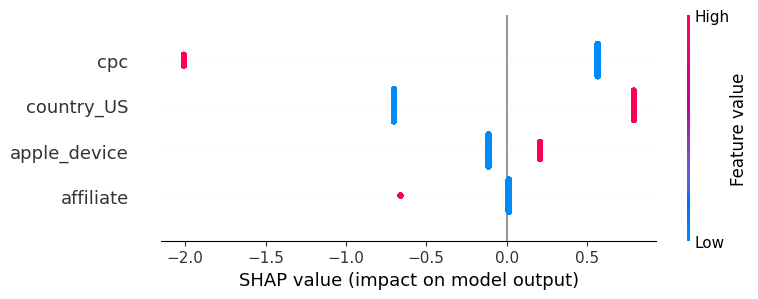

In [58]:
shap.summary_plot(shap_values, X_data_xai_pageviews)

The SHAP summary plot above provides an overview of feature importance and the effects of features on the model's output. Here's what each component of the plot represents:

1. Feature Importance: The features (variables) are listed on the y-axis, ordered by their importance. The most important features (variables) are at the top.
2. SHAP Values: The x-axis represents the SHAP values, which indicate the impact of each feature on the model's prediction.
    * Positive SHAP values push the prediction higher, while negative SHAP values push it lower.
3. Color Coding: Each point on the plot represents a SHAP value for a feature and an instance.
The color of the points represents the feature value (e.g., red for high values and blue for low values).
4. Distribution of SHAP Values: The spread of the points along the x-axis shows the distribution of the SHAP values for each feature.
    * Wider spreads indicate more variability in the feature's impact on the model's predictions.


How can we interpret this plot? 
* Top Features: cpc seems to be most influential 
* Impact Direction: The direction of the SHAP values (left or right) shows whether the feature increases or decreases the prediction. Foe example, cpc has negative impact on the model
* Feature Value Effect: The color gradient helps to understand how the feature values affect the SHAP values. For example, if high feature values (red) are associated with positive SHAP values, it means that high values of that feature increase the prediction.


Let's now see how SHAP can help with local explanation.

In [82]:
#Here, we generate the SHAP values for a single instance - we select the first instance in the data.
#We use iloc that allows to select rows by their index
single_instance = X_data_xai_pageviews.iloc[[0]]


In [83]:
#Here, we can see the dataframe that we are using to generate the SHAP values
single_instance

,cpc,affiliate,apple_device,country_US
36548,0,0,1,1


In [84]:
#Here, we generate the SHAP values for a single instance
shap_values_single = explainer(single_instance)

In [85]:
#Here, we generate the force plot for the single instance
shap.force_plot(explainer.expected_value, shap_values_single.values, single_instance)

This plot shows which features lead to the prediction of 4.85 for the first case in the dataset. 

How to interpret this plot?
* Base Value: The starting point of the horizontal axis, representing the average model output. Here, the model predicts 3.27 on average.
* Prediction Value: f(x), representing the final prediction for the instance. For the first row in the data, the prediction is 4.85 - higher than the average.
* Bars: Each bar represents a feature's contribution to the prediction.
    * Positive Contribution: Bars extending to the right, indicating features that increase the prediction. In this case, all the features contribute positively: the predicted score is higher than average as apple_device is 1, cpc 0 and country_US 1.
    * Negative Contribution: Bars extending to the left, indicating features that decrease the prediction.


## Probabilities for leaving the website using Logistic Regression


In [86]:
logit_clf = LogisticRegression(max_iter=1000, fit_intercept = True)


In [87]:
logit_clf.fit(data[['cpc', 'affiliate','apple_device', 'country_US']], data['isExit'])

LogisticRegression(max_iter=1000)

### Using SHAP for Explainable AI

Here I repeat the same steps as done earlier for SHAP. I just change the variables

Selecting the data needed

Selecting the information needed for SHAP. X are the features (independent variables).

In [89]:
#Here, we slice the data into the features - this dataframe contains only the features
X_data_xai_isexit = data_lime_pageviews[['cpc', 'affiliate', 'apple_device', 'country_US']]


In [90]:
#Here, we create the explainer object that will be used to generate the SHAP values. We provide it with the model and the data that we want to explain
explainer = shap.Explainer(logit_clf, X_data_xai_isexit)


In [91]:
#Here, we generate the SHAP values
shap_values = explainer(X_data_xai_isexit)


First, let's start with global explanation. Here, we want to know relative importance of all features (independent variables) for the model.

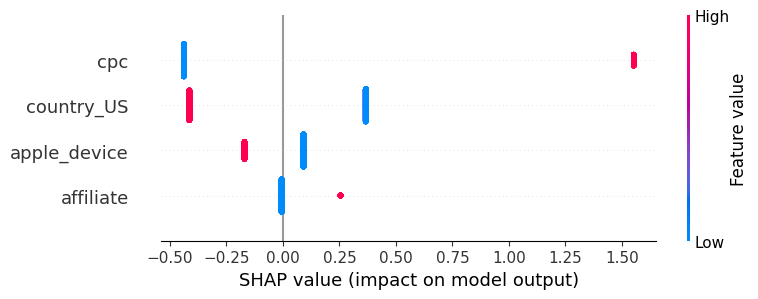

In [92]:
shap.summary_plot(shap_values, X_data_xai_isexit)

How can we interpret this plot? 
* Top Features: cpc seems to be most influential as well
* Impact Direction: For example, cpc has negative impact on the model
* Feature Value Effect: The color gradient helps to understand how the feature values affect the SHAP values. For example, cpc is blue meaning it decreases model prediction.


Let's now see how SHAP can help with local explanation.

In [93]:
#Here, we generate the SHAP values for a single instance - we select the first instance in the data.
#We use iloc that allows to select rows by their index
single_instance = X_data_xai_isexit.iloc[[0]]


In [94]:
#Here, we can see the dataframe that we are using to generate the SHAP values
single_instance

,cpc,affiliate,apple_device,country_US
36548,0,0,1,1


In [95]:
#Here, we generate the SHAP values for a single instance
shap_values_single = explainer(single_instance)

In [96]:
#Here, we generate the force plot for the single instance
shap.force_plot(explainer.expected_value, shap_values_single.values, single_instance)

This plot shows which features lead to the prediction of -0.65 for the first case in the dataset. 

How to interpret this plot?
* Base Value: The starting point of the horizontal axis, representing the average model output. Here, the model predicts 0.38 on average.
* Prediction Value: f(x), representing the final prediction for the instance. For the first row in the data, the prediction is -0.65 - lower than the average.
* Bars: Each bar represents a feature's contribution to the prediction.
    * Positive Contribution: Bars extending to the right, indicating features that increase the prediction. 
    * Negative Contribution: Bars extending to the left, indicating features that decrease the prediction. In this case, all the features contribute negatively: the predicted score is lower than average as apple_device is 1, cpc 0 and country_US 1.


Now, try to predict different cases using SHAP!